**Mount google drive**

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

**Import the required libraries**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings # Ignore all warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv('../data/processed_data/trip_riders_drivers_df.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 36 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   trip_id             200000 non-null  object 
 1   user_id             200000 non-null  object 
 2   driver_id           200000 non-null  object 
 3   fare                200000 non-null  float64
 4   surge_multiplier    200000 non-null  float64
 5   tip                 200000 non-null  float64
 6   payment_type        200000 non-null  object 
 7   pickup_time         200000 non-null  object 
 8   dropoff_time        200000 non-null  object 
 9   pickup_lat          200000 non-null  float64
 10  pickup_lng          200000 non-null  float64
 11  dropoff_lat         200000 non-null  float64
 12  dropoff_lng         200000 non-null  float64
 13  weather             200000 non-null  object 
 14  loyalty_status      200000 non-null  object 
 15  user_signup_date    200000 non-nul

**columns data types conversion**

In [8]:
# Convert pickup and dropoff times safely, keeping timezone info
df['pickup_time'] = pd.to_datetime(df['pickup_time'], utc=True, errors='coerce')
df['dropoff_time'] = pd.to_datetime(df['dropoff_time'], utc=True, errors='coerce')
df['user_signup_date'] = pd.to_datetime(df['user_signup_date'], utc=True, errors='coerce')
df['driver_signup_date'] = pd.to_datetime(df['driver_signup_date'], utc=True, errors='coerce')
df['last_active'] = pd.to_datetime(df['last_active'], utc=True, errors='coerce')
df['dropoff_date'] = pd.to_datetime(df['dropoff_date'], utc=True, errors='coerce')



# Check the datatypes
print(df['pickup_time'].dtype)
print(df['dropoff_time'].dtype)
print(df['user_signup_date'].dtype)
print(df['driver_signup_date'].dtype)

datetime64[ns, UTC]
datetime64[ns, UTC]
datetime64[ns, UTC]
datetime64[ns, UTC]


#

## **Exploratory Data Analysis**

**Weather vs. Surge**

In [9]:
weather_surge = df.groupby('weather')['surge_multiplier'].mean().reset_index()
weather_surge

,weather,surge_multiplier
0,Cloudy,1.073579
1,Foggy,1.073207
2,Rainy,1.411209
3,Sunny,1.074334


**The impact of Weather on Fare**

In [10]:
weather_fare = df.groupby('weather')['fare'].mean().reset_index()
weather_fare


,weather,fare
0,Cloudy,14.473759
1,Foggy,14.478765
2,Rainy,19.041042
3,Sunny,14.497673


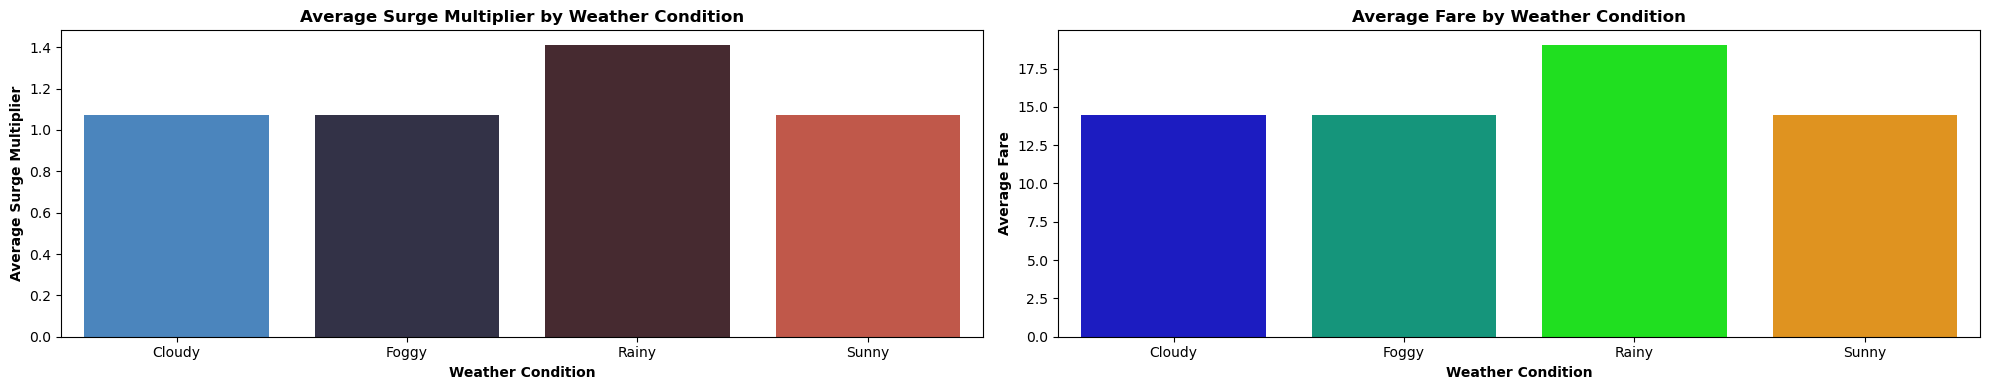

In [11]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
sns.barplot(x='weather', y='surge_multiplier', data=weather_surge, palette='icefire')
plt.xlabel('Weather Condition', weight='bold')
plt.ylabel('Average Surge Multiplier', weight='bold')
plt.title('Average Surge Multiplier by Weather Condition', weight='bold')

plt.subplot(1, 2, 2)
sns.barplot(x='weather', y='fare', data=weather_fare, palette='nipy_spectral')
plt.title('Average Fare by Weather Condition', weight='bold')
plt.xlabel('Weather Condition', weight='bold')
plt.ylabel('Average Fare', weight='bold')
plt.tight_layout()
plt.show();

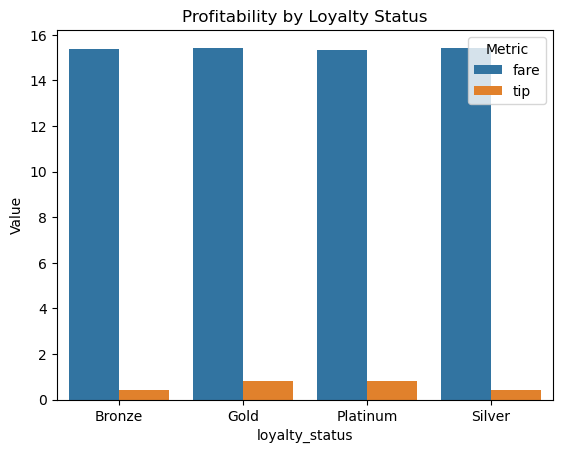

In [12]:
# Average fare and tip per loyalty tier
loyalty_stats = df.groupby('loyalty_status')[['fare', 'tip']].mean().reset_index()
loyalty_melted = loyalty_stats.melt(id_vars='loyalty_status', var_name='Metric', value_name='Value')

sns.barplot(data=loyalty_melted, x='loyalty_status', y='Value', hue='Metric')
plt.title('Profitability by Loyalty Status')
plt.show();

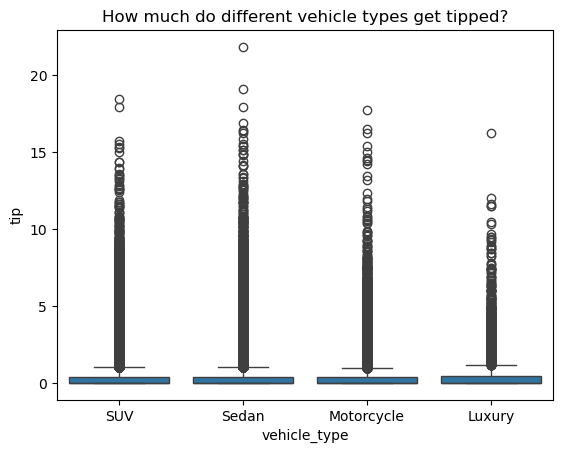

In [13]:
sns.boxplot(data=df, x='vehicle_type', y='tip')
plt.title('How much do different vehicle types get tipped?')
plt.show()

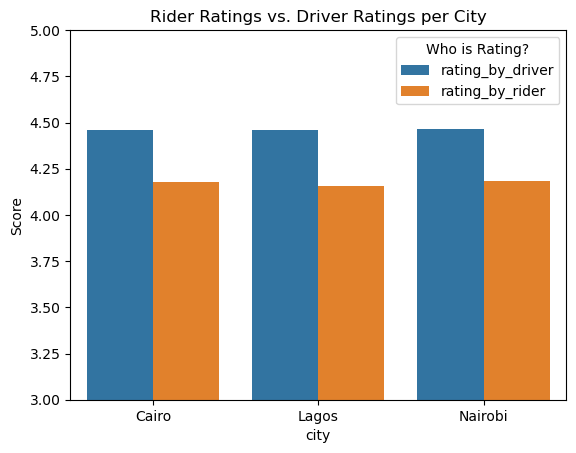

In [14]:
gap_data = df.groupby('city')[['rating_by_driver', 'rating_by_rider']].mean().reset_index()
gap_melted = gap_data.melt(id_vars='city', var_name='Who is Rating?', value_name='Score')

sns.barplot(data=gap_melted, x='city', y='Score', hue='Who is Rating?')
plt.ylim(3, 5) # Focus on the top of the scale
plt.title('Rider Ratings vs. Driver Ratings per City')
plt.show()

#

**Surge Elasticity (Price Sensitivity per City):** Looking at how fare changes as surge_multiplier increases in each city.

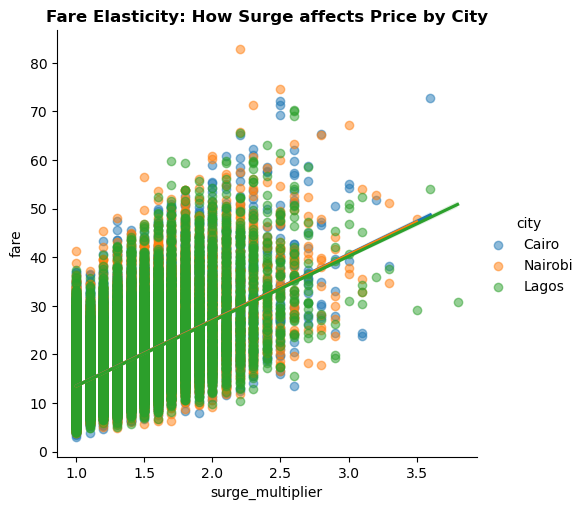

In [15]:
sns.lmplot(data=df, x='surge_multiplier', y='fare', hue='city', scatter_kws={'alpha':0.5})
plt.title('Fare Elasticity: How Surge affects Price by City', weight='bold')
plt.show()

**Payment Method by Tips**

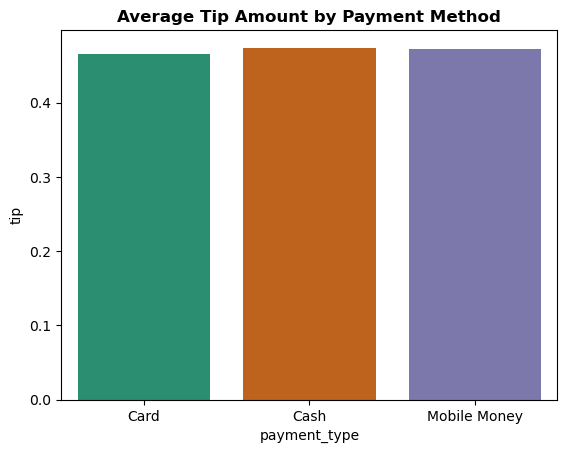

In [16]:
avg_tips = df.groupby('payment_type')['tip'].mean().reset_index()
sns.barplot(data=avg_tips, x='payment_type', y='tip', palette='Dark2')
plt.title('Average Tip Amount by Payment Method', weight='bold')
plt.show()

#

**Revenue Leakage (Lost Fares from Low Acceptance):** Estimating the total revenue if all drivers had a 100% acceptance rate.

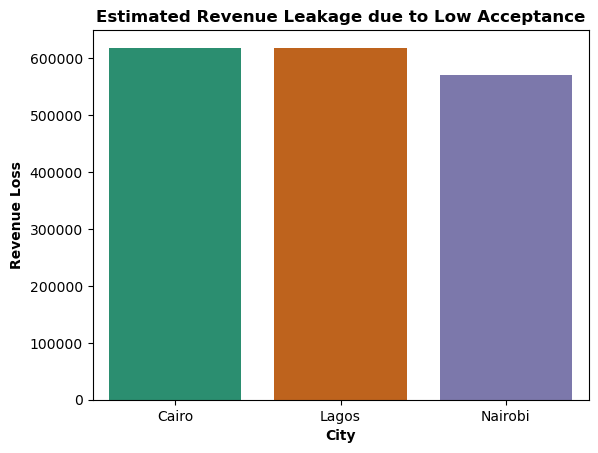

In [17]:
df['potential_fare'] = df['fare'] / df['acceptance_rate']                 # engineering the 'potential_fare' feature
leakage = df.groupby('city')[['fare', 'potential_fare']].sum().reset_index()
leakage['lost_revenue'] = leakage['potential_fare'] - leakage['fare']
sns.barplot(data=leakage, x='city', y='lost_revenue', palette='Dark2')
plt.title('Estimated Revenue Leakage due to Low Acceptance', weight='bold')
plt.xlabel('City', weight='bold')
plt.ylabel('Revenue Loss', weight='bold')
plt.show();

#

**Group 2: Retention & Churn**

**Drivers Rating by Churn Probability**

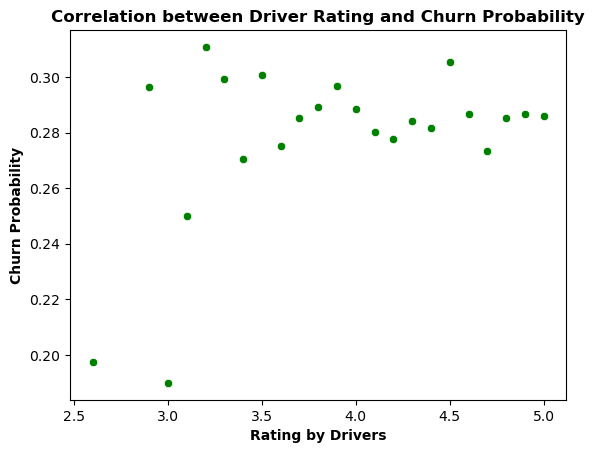

In [18]:
from matplotlib import colors
# Grouping by rating to see average churn probability
driver_rating_churn = df.groupby('rating_by_driver')['churn_prob'].mean().reset_index()
sns.scatterplot(data=driver_rating_churn, x='rating_by_driver', y='churn_prob', color='green')
plt.title('Correlation between Driver Rating and Churn Probability', weight='bold')
plt.xlabel('Rating by Drivers', weight='bold')
plt.ylabel('Churn Probability', weight='bold')
plt.show();

**Riders Rating by Churn Probability**

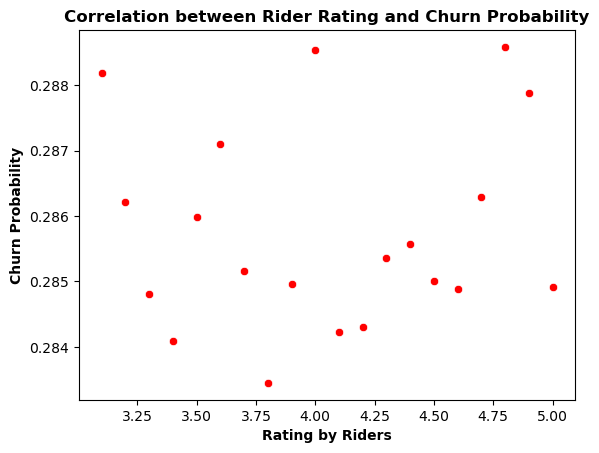

In [19]:
from matplotlib import colors
# Grouping by rating to see average churn probability
rider_rating_churn = df.groupby('rating_by_rider')['churn_prob'].mean().reset_index()
sns.scatterplot(data=rider_rating_churn, x='rating_by_rider', y='churn_prob', color='red')
plt.title('Correlation between Rider Rating and Churn Probability', weight='bold')
plt.xlabel('Rating by Riders', weight='bold')
plt.ylabel('Churn Probability', weight='bold')
plt.show();

#

**High Surge Impact on Rider Loyalty and Churn Probability**

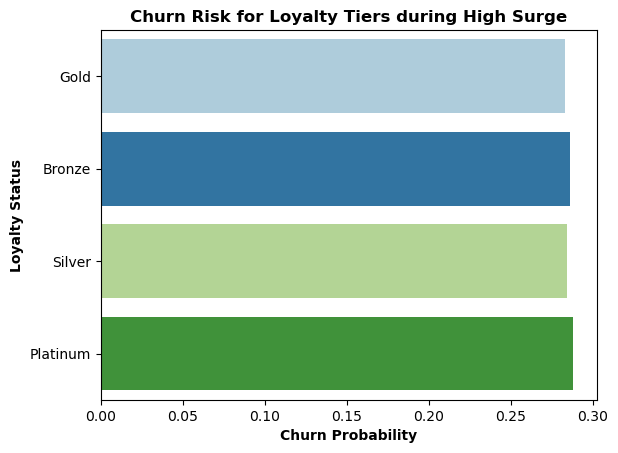

In [20]:
# Look at high surge trips (>1.5) and churn probability
high_surge = df[df['surge_multiplier'] > 1.5].reset_index()
(high_surge.groupby('loyalty_status')['churn_prob'].mean()*100).reset_index()
sns.barplot(data=high_surge, y='loyalty_status', x='churn_prob', errorbar=None, palette='Paired')
plt.title('Churn Risk for Loyalty Tiers during High Surge', weight='bold')
plt.ylabel('Loyalty Status', weight='bold')
plt.xlabel('Churn Probability', weight='bold')
plt.show();

#

**Weather by Driver Acceptance Rate**

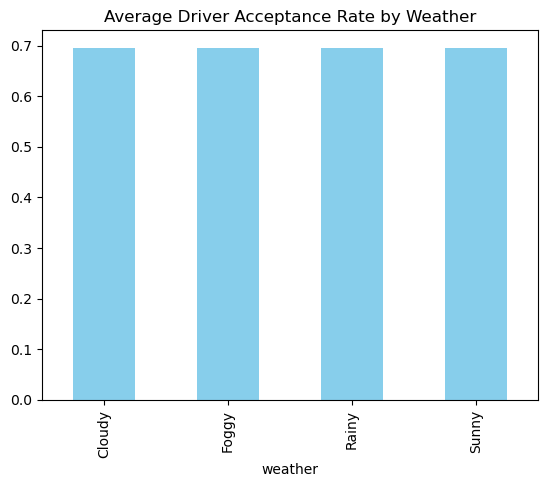

In [21]:
# Does weather decrease acceptance rates?
weather_perf = df.groupby('weather')['acceptance_rate'].mean()
weather_perf.plot(kind='bar', color='skyblue')
plt.title('Average Driver Acceptance Rate by Weather')
plt.show()

#

**weather, fare, surge**

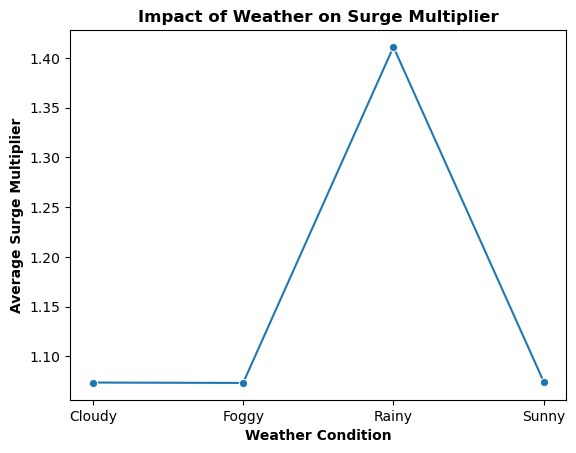

In [22]:
weather_surge = df.groupby('weather')['surge_multiplier'].mean().reset_index()
weather_surge
sns.lineplot(data=weather_surge, x='weather', y='surge_multiplier', marker='o')
plt.title('Impact of Weather on Surge Multiplier', weight='bold')
plt.xlabel('Weather Condition', weight='bold')
plt.ylabel('Average Surge Multiplier', weight='bold')
plt.show();

#

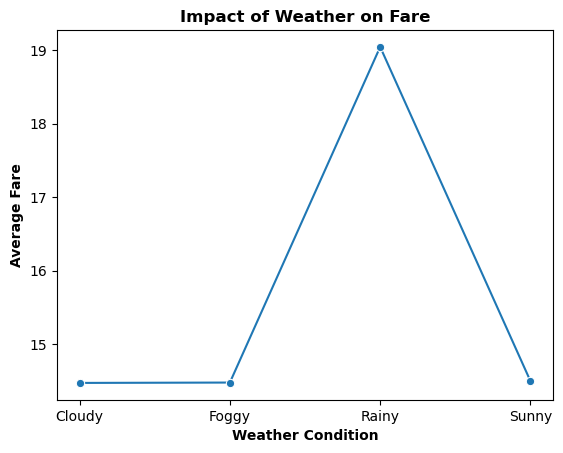

In [23]:
weather_fare = df.groupby('weather')['fare'].mean().reset_index()
weather_fare
sns.lineplot(data=weather_fare, x='weather', y='fare', marker='o')
plt.title('Impact of Weather on Fare', weight='bold')
plt.xlabel('Weather Condition', weight='bold')
plt.ylabel('Average Fare', weight='bold')
plt.show();

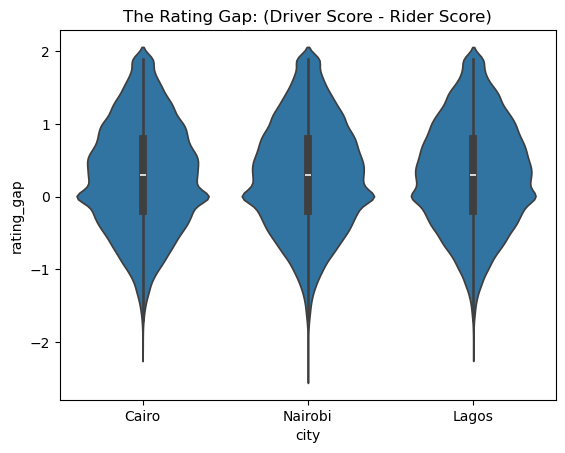

In [24]:
df['rating_gap'] = df['rating_by_driver'] - df['rating_by_rider']
sns.violinplot(data=df, x='city', y='rating_gap')
plt.title('The Rating Gap: (Driver Score - Rider Score)')
plt.show()

#

In [25]:
df.columns

Index(['trip_id', 'user_id', 'driver_id', 'fare', 'surge_multiplier', 'tip',
       'payment_type', 'pickup_time', 'dropoff_time', 'pickup_lat',
       'pickup_lng', 'dropoff_lat', 'dropoff_lng', 'weather', 'loyalty_status',
       'user_signup_date', 'age', 'rating_by_driver', 'churn_prob',
       'rating_by_rider', 'vehicle_type', 'driver_signup_date', 'last_active',
       'city', 'acceptance_rate', 'dropoff_date', 'dropoff_day',
       'trip_duration_mins', 'rider_age_group', 'pickup_hour', 'pickup_date',
       'pickup_day', 'pickup_month', 'pickup_year', 'pickup_period',
       'pickup_season', 'potential_fare', 'rating_gap'],
      dtype='object')

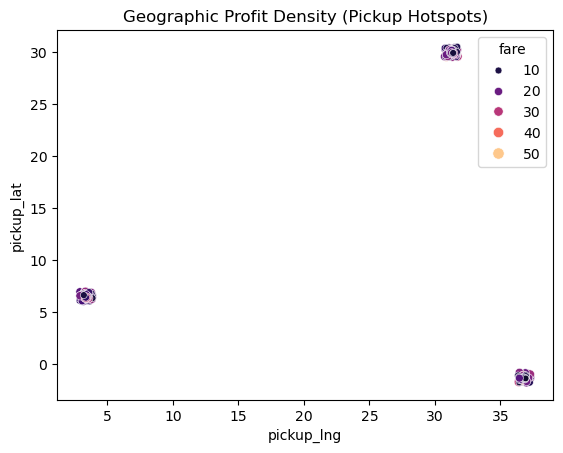

In [26]:
# Mapping the highest fare areas
sns.scatterplot(data=df.sample(1000), x='pickup_lng', y='pickup_lat', size='fare', hue='fare', palette='magma')
plt.title('Geographic Profit Density (Pickup Hotspots)')
plt.show()

**Pickup Period vs. Tip Likelihood**

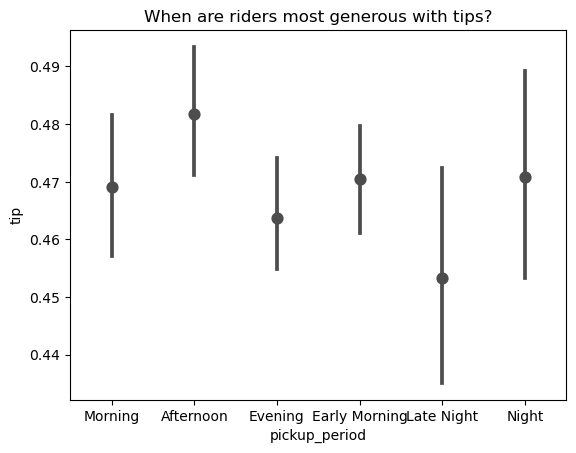

In [27]:
# Assuming 'pickup_period' (Morning, Night, etc.) is in the data or created
sns.pointplot(data=df, x='pickup_period', y='tip', join=False, color='0.3')
plt.title('When are riders most generous with tips?')
plt.show()

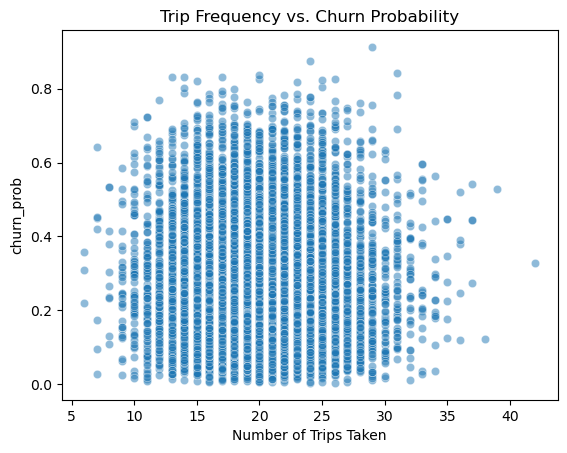

In [28]:
user_trips = df.groupby('user_id').agg({'trip_id':'count', 'churn_prob':'mean'})
sns.scatterplot(data=user_trips, x='trip_id', y='churn_prob', alpha=0.5)
plt.title('Trip Frequency vs. Churn Probability')
plt.xlabel('Number of Trips Taken')
plt.show()

gPT

In [29]:
# Group rider behavior and average churn probability
churn_drivers = (
    df.groupby('user_id')
      .agg({
          'churn_prob': 'mean',
          'fare': 'mean',
          'rating_by_rider': 'mean',
          'surge_multiplier': 'mean',
          'trip_id': 'count'
      }).reset_index()
      .rename(columns={'trip_id': 'total_trips'})
)

# View the result
churn_drivers.head()


,user_id,churn_prob,fare,rating_by_rider,surge_multiplier,total_trips
0,R00000,0.142431,14.642000,4.252000,1.096000,25
1,R00001,0.674161,12.895000,4.135714,1.071429,14
2,R00002,0.510379,15.791250,4.150000,1.191667,24
3,R00003,0.244779,13.496667,4.111111,1.155556,9
4,R00004,0.269960,16.776875,4.156250,1.262500,16


In [30]:
df.to_csv('C:/Users/User/Desktop/ridewise/data/processed_data/trip_riders_drivers_eda_df.csv', index=False)
print('The dataframe was saved successfully')

The dataframe was saved successfully
